In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def cm2inch(value):
    return value/2.54

In [3]:
#plotsize_subplots = (cm2inch(19),cm2inch(3.5))
#plotsize_subplots = (cm2inch(19),cm2inch(9))
plotsize_subplots = (7,7)

fontsize_axis = 9
fontsize_labels = 10
fontsize_legends = 10

plt.rcParams.update({'figure.figsize': plotsize_subplots,
                     'axes.titlesize': fontsize_labels,
                     'axes.labelsize': fontsize_labels,
                     'ytick.labelsize': 'small'})

In [4]:
def calculate_T_conn_and_memory(df):
    """Calculate T_conn and memory_per_vp"""
    
    # For MAM, T_conns is divided into T_network_global and T_connect:
    if 'T_conns_min' not in list(df) and 'T_network_global_min' in list(df): 
        df['T_conns_min'] = df['T_network_global_min'] + df['T_connect_min']
        df['T_conns_max'] = df['T_network_global_max'] + df['T_connect_max']
    
    df['T_bld_xn'] = df['T_conns_min'] + df['T_ini_max']
    df['T_bld_nx'] = df['T_conns_max'] + df['T_ini_min']
    df['Conn. Total']   = df[['T_bld_xn', 'T_bld_nx']].min(axis=1)
    df['Conn. Creation (min)'] = df['T_conns_min']
    df['Conn. Exchange (min)'] = df['T_ini_min']

    
    if 'NUM_VPS' not in list(df):
        df['N_VP'] = df['NUMBER_OF_NODES']*df['TASKS_PER_NODE']*df['THREADS_PER_TASK']
    else:
        df['N_VP'] = df['NUM_VPS']
    if np.isnan(df['VSize_sum']).all():  # Population model
        # Population model does not simulate, VSize_mem is therefore equal to VSize_ini_sum as this is the
        # end of the benchmark
        df['VSize_sum'] = df['VSize_ini_sum']
    if 'VSize_mem_sum' not in list(df) and 'VSize_nodes_sum' not in list(df):  # MAM
        df['VSize_mem_sum'] = df['VSize_net_sum']  # VSize_mem_sum is called VSize_net_sum for MAM
        df['VSize_nodes_sum'] = np.NaN  # MAM model does not have VSize_nodes_sum

    # Vi har MiB = 1024**2 B
    # Verdien vi får fra NEST er i KiB (http://www.nest-simulator.org/helpindex/sli/memory_thisjob.html)

    df['connections'] = ((df['VSize_mem_sum']-df['VSize_nodes_sum'])/df['N_VP'])*1024/1024**3
    df['ini'] = ((df['VSize_ini_sum']-df['VSize_mem_sum'])/df['N_VP'])*1024/1024**3
    df['other'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3 - df['connections'] - df['ini']
    df['Memory per VP'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3

    return df

In [5]:
def plot_compare(df, name, values=None, index=None, legend_loc='lower right', rot=45, one_row=True, logy=False,
                 color=None, plot_T_sim=True, plot_kind='bar', title=''):
    """Plot times for different cases"""
    
    if not values:
        values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per VP']
    if not index:
        index='N_VP'
    if plot_T_sim:
        df['Simulation time'] = df['T_sim']
        values.insert(3, 'Simulation time')
    df_p = pd.pivot_table(df, index=index, columns='Case', values=values)

    # Make subplots
    if one_row:
        fig, axes = plt.subplots(nrows=1, ncols=len(values))
        if len(values) == 1:
            axes = [axes]
                
        for indx, val_name in enumerate(values):
            df_p[val_name].plot(kind=plot_kind, ax = axes[indx], title=val_name, fontsize=fontsize_axis, rot=rot,
                                logy=logy, legend=False, color=color)
        axes[0].legend(fontsize=fontsize_legends, loc=legend_loc)
        
        plt.subplots_adjust(wspace=0.5)
    else:
        plotsize_subplots = (cm2inch(19),cm2inch(9))
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=plotsize_subplots)

        df_p['Conn. Creation (min)'].plot(kind='bar', ax = axes[0][0], title='Conn. Creation (min)',
                                          fontsize=fontsize_axis, rot=rot, legend=False)
        axes[0][0].legend(fontsize=fontsize_legends, loc=legend_loc)
        df_p['Conn. Exchange (min)'].plot(kind='bar', ax = axes[0][1], title='Conn. Exchange (min)',
                                          fontsize=fontsize_axis, rot=rot, legend=False)
        df_p['Conn. Total'].plot(kind='bar', ax = axes[1][0], title='Conn. Total', fontsize=fontsize_axis,
                                 rot=rot, legend=False)
        df_p['Memory per VP'].plot(kind='bar', ax = axes[1][1], title='Memory per VP', fontsize=fontsize_axis,
                                   rot=rot, legend=False)

        plt.subplots_adjust(wspace=0.5, hspace=0.7)

    # y-axis labels
    if 'Total Conn. Time per Conn.' in values:  
        axes[0].set_ylabel(r'Time [$\mu$s]')  # Not safe..
    else:
        if one_row:
            axes[0].set_ylabel('Time [s]')
        else:
            axes[0][0].set_ylabel('Time [s]')
            axes[1][0].set_ylabel('Time [s]')
    if 'Memory per VP' in values:
        # Assume memory is last entry in values
        if one_row:
            axes[len(values) - 1].set_ylabel('Memory [GiB]')
        else:
            axes[1][1].set_ylabel('Memory [GiB]')
    elif 'Memory per connection' in values:
        axes[len(values) - 1].set_ylabel('Memory [B]')

    # x-axis labels
    if one_row:
        for ax in axes:
            ax.set_xlabel(index)

    if title:
        fig.suptitle(title, y=1.2)
            
    fig = plt.gcf()
    fig.savefig(name, bbox_inches='tight')
    
    return df_p

Conn. Creation (min)                                                  \
Case          0 NEST 2.20 00 - a641eec1e GOOD 1 - 5998cb611 2 - f2a0565b4   
N_VP                                                                        
36                  47.47               56.66         55.85         56.91   
72                  47.47               56.59         55.71         56.43   
144                 47.41               57.06         55.87         57.00   
288                 47.67               57.37         56.45         57.25   
576                 47.48               58.23         57.32         58.00   
1152                47.59                 NaN           NaN         59.67   

                                                                           \
Case 3 - db126d18a 4 - 43ae44c5d 4 - master with change 5 - cfa213d05 BAD   
N_VP                                                                        
36           57.09         55.96                  70.65             76.53   
72           56.80         55.89                  70.76             76.13   
144          57.11         56.22                  71.56             73.96   
288          57.56         56.65                  71.36             74.96   
576          58.37         57.24                  72.89             74.55   
1152         59.86         58.90                    NaN             76.18   

                                                                          \
Case 5 - cfa213d05 with change 6 - 49cbf90f0 7 - fd68ec101 8 - d8cb2976b   
N_VP                                                                       
36                       56.94         79.91         76.74         74.88   
72                       57.06         79.20         75.90         76.57   
144                      57.48         79.93         75.88         74.86   
288                      58.02         76.47         73.51         73.68   
576                      58.73         77.59         74.11         74.42   
1152                     60.52         77.86           NaN           NaN   

                                     
Case 9 - c777c33 99 - 8f5a5fc1e BAD  
N_VP                                 
36         76.75              69.92  
72         77.24              72.80  
144        75.10              72.66  
288        74.50              71.04  
576        74.50              71.13  
1152         NaN                NaN

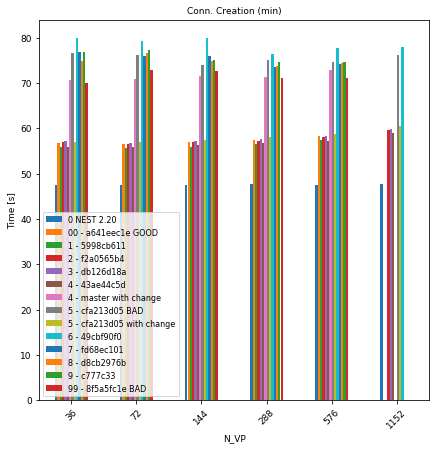

In [6]:
hpc_220 = pd.read_csv('results/hpc_benchmark_2_20_daint.csv')
hpc_220['Case'] = ['0 NEST 2.20'] * len(hpc_220)


hpc_3_a6 = pd.read_csv('results/hpc_benchmark_3_0_a641eec1e_daint.csv') # GOOD
hpc_3_a6['Case'] = ['00 - a641eec1e GOOD'] * len(hpc_3_a6)
hpc_3_8f = pd.read_csv('results/hpc_benchmark_3_0_8f5a5fc1e_daint.csv') # BAD
hpc_3_8f['Case'] = ['99 - 8f5a5fc1e BAD'] * len(hpc_3_8f)

# Bisect:
hpc_3_c7 = pd.read_csv('results/bisect/hpc_benchmark_bisect_c777c33_daint.csv')
hpc_3_c7['Case'] = ['9 - c777c33'] * len(hpc_3_c7)
hpc_3_d8 = pd.read_csv('results/bisect/hpc_benchmark_bisect_d8cb2976b_daint.csv')
hpc_3_d8['Case'] = ['8 - d8cb2976b'] * len(hpc_3_d8)
hpc_3_59 = pd.read_csv('results/bisect/hpc_benchmark_bisect_5998cb611_daint.csv')
hpc_3_59['Case'] = ['1 - 5998cb611'] * len(hpc_3_59)
hpc_3_f2 = pd.read_csv('results/bisect/hpc_benchmark_bisect_f2a0565b4_daint.csv')
hpc_3_f2['Case'] = ['2 - f2a0565b4'] * len(hpc_3_f2)
hpc_3_fd = pd.read_csv('results/bisect/hpc_benchmark_bisect_fd68ec101_daint.csv')
hpc_3_fd['Case'] = ['7 - fd68ec101'] * len(hpc_3_fd)
hpc_3_49 = pd.read_csv('results/bisect/hpc_benchmark_bisect_49cbf90f0_daint.csv')
hpc_3_49['Case'] = ['6 - 49cbf90f0'] * len(hpc_3_49)
hpc_3_db = pd.read_csv('results/bisect/hpc_benchmark_bisect_db126d18a_daint.csv')
hpc_3_db['Case'] = ['3 - db126d18a'] * len(hpc_3_db)

# problem:
hpc_3_cf = pd.read_csv('results/bisect/hpc_benchmark_bisect_cfa213d05_daint.csv')
hpc_3_cf['Case'] = ['5 - cfa213d05 BAD'] * len(hpc_3_cf)
hpc_3_cf_1 = pd.read_csv('results/bisect/hpc_benchmark_bisect_cfa213d05_1_daint.csv')
hpc_3_cf_1['Case'] = ['5 - cfa213d05 with change'] * len(hpc_3_cf_1)
hpc_3_cf_2 = pd.read_csv('results/bisect/hpc_benchmark_bisect_cfa213d05_2_daint.csv')
hpc_3_cf_2['Case'] = ['5 - cfa213d05 with change'] * len(hpc_3_cf_2)

# prev.
hpc_3_43 = pd.read_csv('results/bisect/hpc_benchmark_bisect_43ae44c5d_daint.csv')
hpc_3_43['Case'] = ['4 - 43ae44c5d'] * len(hpc_3_43)
hpc_3_c6 = pd.read_csv('results/bisect/hpc_benchmark_bisect_c690b7a3d_1_daint.csv')
hpc_3_c6['Case'] = ['4 - master with change'] * len(hpc_3_c6)

#cfa213d0586afa8224dd2cc932283ee597d500d4 is the first bad commit
#commit cfa213d0586afa8224dd2cc932283ee597d500d4
#Author: Stine Vennemo <stine.vennemo@gmail.com>
#Date:   Fri Sep 25 11:53:38 2020 +0200

#    restructure if/else and add provides_long() to ConnParameter

# nestkernel/conn_builder.cpp   | 148 ++++++++++++++----------------------------
# nestkernel/conn_parameter.cpp |   2 +
# nestkernel/conn_parameter.h   |  32 ++++++++-
# 3 files changed, 82 insertions(+), 100 deletions(-)


hpc = pd.concat([hpc_220,  hpc_3_a6, hpc_3_8f, hpc_3_c7, hpc_3_d8, hpc_3_59, hpc_3_f2,
                 hpc_3_fd, hpc_3_49, hpc_3_db, hpc_3_cf, hpc_3_cf_2, hpc_3_43, hpc_3_c6])

hpc = calculate_T_conn_and_memory(hpc)
values=['Conn. Creation (min)']
hpc_p = plot_compare(hpc, 'figures/bisect/hpc_benchmark_weak_scaling.pdf', values=values, plot_T_sim=False,
                     legend_loc='lower left')

hpc_p

Conn. Creation (min)                                          \
Case   36ccfa5d4 - update 3cae38a4b - fix 8f5a5fc1e BAD NEST 2.20   
N_VP                                                                
36                  67.17           54.12         69.92     47.47   
72                  67.24           54.38         72.80     47.47   
144                 67.10           54.53         72.66     47.41   
288                 67.62           55.00         71.04     47.67   
576                 68.42           55.90         71.13     47.48   
1152                  NaN             NaN           NaN     47.59   

                    Conn. Exchange (min)                                \
Case a641eec1e GOOD   36ccfa5d4 - update 3cae38a4b - fix 8f5a5fc1e BAD   
N_VP                                                                     
36            56.66                80.59           79.30         79.20   
72            56.59                78.76           81.31         81.26   
144           57.06                84.45           82.17         81.98   
288           57.37                86.10           85.92         84.68   
576           58.23                89.22           89.89         89.41   
1152            NaN                  NaN             NaN           NaN   

                               ...      Memory per VP                  \
Case NEST 2.20 a641eec1e GOOD  ... 36ccfa5d4 - update 3cae38a4b - fix   
N_VP                           ...                                      
36       51.06          77.80  ...           2.888107        2.887291   
72       54.56          80.93  ...           2.893680        2.893434   
144      56.86          80.88  ...           2.979109        2.978171   
288      63.50          85.66  ...           2.984580        2.984314   
576      79.77          89.80  ...           3.065541        3.066102   
1152    108.10            NaN  ...                NaN             NaN   

                                               Simulation time  \
Case 8f5a5fc1e BAD NEST 2.20 a641eec1e GOOD 36ccfa5d4 - update   
N_VP                                                             
36        2.886640  2.819082       2.890740             203.90   
72        2.892702  2.834828       2.893303             207.58   
144       2.978537  2.908171       2.980969             210.43   
288       2.983866  2.913480       2.983796             224.76   
576       3.074016  3.051638       3.068073             243.48   
1152           NaN  3.395655            NaN                NaN   

                                                             
Case 3cae38a4b - fix 8f5a5fc1e BAD NEST 2.20 a641eec1e GOOD  
N_VP                                                         
36            201.72        203.83    191.81         204.21  
72            210.98        211.11    199.87         207.42  
144           216.46        217.54    199.12         211.14  
288           228.30        230.29    212.72         225.03  
576           240.23        242.58    228.70         240.17  
1152             NaN           NaN    267.55            NaN  

[6 rows x 25 columns]

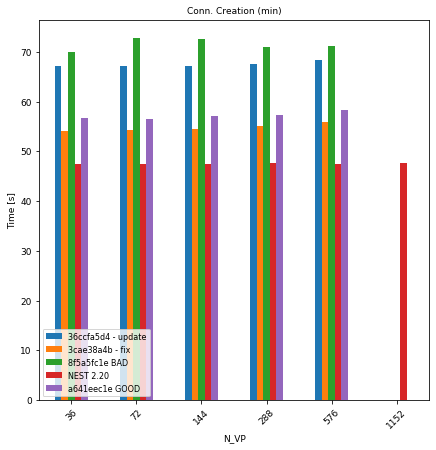

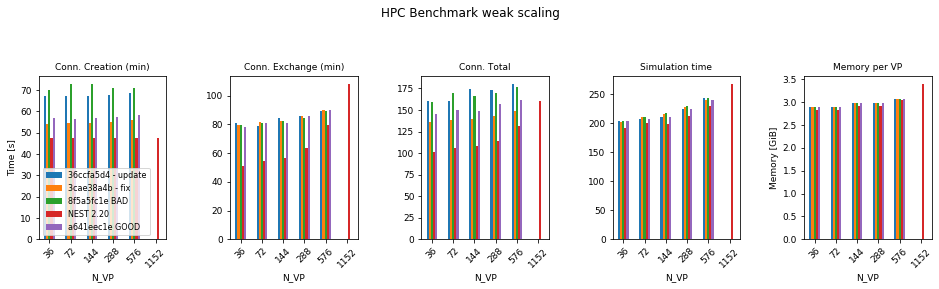

In [11]:
hpc_220 = pd.read_csv('results/hpc_benchmark_2_20_daint.csv')
hpc_220['Case'] = ['NEST 2.20'] * len(hpc_220)


hpc_3_a6 = pd.read_csv('results/hpc_benchmark_3_0_a641eec1e_daint.csv') # GOOD
hpc_3_a6['Case'] = ['a641eec1e GOOD'] * len(hpc_3_a6)
hpc_3_8f = pd.read_csv('results/hpc_benchmark_3_0_8f5a5fc1e_daint.csv') # BAD
hpc_3_8f['Case'] = ['8f5a5fc1e BAD'] * len(hpc_3_8f)

hpc_3_3c = pd.read_csv('results/bisect/hpc_benchmark_bisect_3cae38a4b_daint.csv')
hpc_3_3c['Case'] = ['3cae38a4b - fix'] * len(hpc_3_3c)

hpc_3_36 = pd.read_csv('results/hpc_benchmark_36ccfa5d4_daint.csv')
hpc_3_36['Case'] = ['36ccfa5d4 - update'] * len(hpc_3_36)

hpc_fix = pd.concat([hpc_220,  hpc_3_a6, hpc_3_8f, hpc_3_3c, hpc_3_36])

hpc_fix = calculate_T_conn_and_memory(hpc_fix)
values=['Conn. Creation (min)']
hpc_fix_p = plot_compare(hpc_fix, 'figures/bisect/hpc_benchmark_weak_scaling_connection_fix.png', values=values,
                         plot_T_sim=False,
                         legend_loc='lower left')

plotsize_subplots = (16,3)
plt.rcParams.update({'figure.figsize': plotsize_subplots})

hpc_fix_p = plot_compare(hpc_fix, 'figures/bisect/hpc_benchmark_weak_scaling_fix.png',
                         plot_T_sim=True,
                         legend_loc='lower left', title='HPC Benchmark weak scaling')

plt.rcParams.update({'figure.figsize': (7,7)})

hpc_fix_p

Conn. Creation (min)                                          \
Case   36ccfa5d4 - update 3cae38a4b - fix 8f5a5fc1e BAD NEST 2.20   
N_VP                                                                
36                  26.25           24.19         37.08     22.40   
72                  26.82           22.38         33.50     22.10   
144                 26.46           22.37         34.09     22.22   
288                 26.82           22.46         32.25     20.92   
576                 27.19           22.79         30.28     21.31   
1152                27.21           23.35         33.68     21.40   

                    Conn. Exchange (min)                                \
Case a641eec1e GOOD   36ccfa5d4 - update 3cae38a4b - fix 8f5a5fc1e BAD   
N_VP                                                                     
36            20.65                46.92           47.54         50.27   
72            21.31                54.08           53.33         54.58   
144           21.52                62.76           61.18         54.96   
288           21.89                63.02           60.96         63.57   
576           21.85                70.22           71.74         71.22   
1152          22.39                78.78           78.05         77.52   

                               ...      Memory per VP                  \
Case NEST 2.20 a641eec1e GOOD  ... 36ccfa5d4 - update 3cae38a4b - fix   
N_VP                           ...                                      
36       51.89          47.11  ...           2.844088        2.844087   
72       39.23          51.25  ...           2.846042        2.844088   
144      43.92          55.23  ...           2.921780        2.921941   
288      48.43          69.58  ...           2.932549        2.932494   
576      76.26          73.76  ...           2.975363        2.972340   
1152       NaN          94.96  ...           3.396102        3.395532   

                                               Simulation time  \
Case 8f5a5fc1e BAD NEST 2.20 a641eec1e GOOD 36ccfa5d4 - update   
N_VP                                                             
36        2.844087  3.074158       2.844090             216.47   
72        2.844088  3.096727       2.844741             174.58   
144       2.918252  3.198290       2.910578             241.93   
288       2.934528  3.229540       2.932673             263.21   
576       2.974829  3.285584       2.967887             293.67   
1152      3.393426       NaN       3.390869             415.78   

                                                             
Case 3cae38a4b - fix 8f5a5fc1e BAD NEST 2.20 a641eec1e GOOD  
N_VP                                                         
36            214.11        136.77    131.98         135.99  
72            177.17        224.27    200.90         227.08  
144           241.91        233.14    238.85         166.32  
288           273.04        249.50    244.31         232.18  
576           347.91        299.07    275.03         289.45  
1152          399.94        383.38       NaN         416.24  

[6 rows x 25 columns]

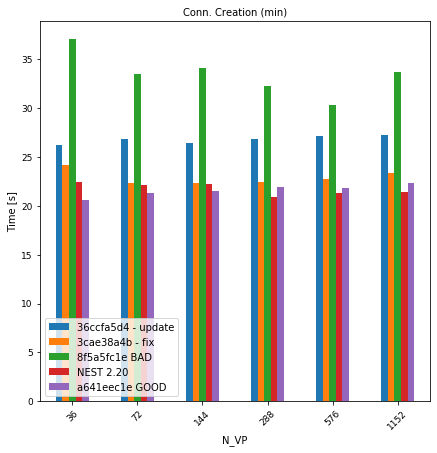

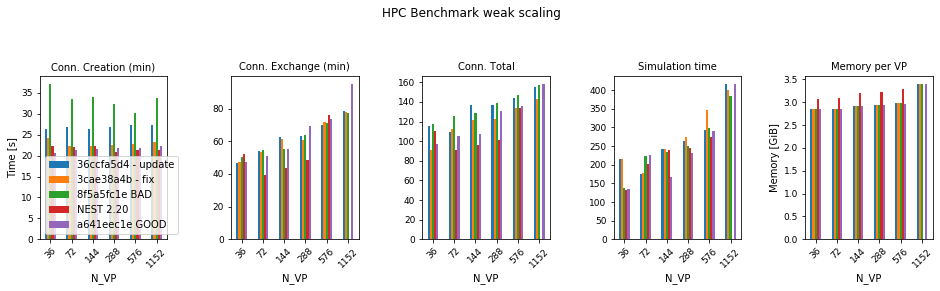

In [12]:
hpc_220_j = pd.read_csv('results/jusuf/hpc_benchmark_2_20_jusuf.csv')
hpc_220_j['Case'] = ['NEST 2.20'] * len(hpc_220_j)

hpc_3_a6_j = pd.read_csv('results/jusuf/hpc_benchmark_3_0_a641eec_jusuf.csv') # GOOD
hpc_3_a6_j['Case'] = ['a641eec1e GOOD'] * len(hpc_3_a6_j)
hpc_3_28_j = pd.read_csv('results/jusuf/hpc_benchmark_3_0_2869b63_jusuf.csv') # BAD
hpc_3_28_j['Case'] = ['8f5a5fc1e BAD'] * len(hpc_3_28_j)

hpc_3_3c_j = pd.read_csv('results/jusuf/hpc_benchmark_3_0_3cae38a_jusuf.csv')
hpc_3_3c_j['Case'] = ['3cae38a4b - fix'] * len(hpc_3_3c_j)

hpc_3_36_j = pd.read_csv('results/jusuf/hpc_benchmark_3_0_36ccfa5_jusuf.csv')
hpc_3_36_j['Case'] = ['36ccfa5d4 - update'] * len(hpc_3_36_j)

hpc_fix_j = pd.concat([hpc_220_j, hpc_3_a6_j, hpc_3_28_j, hpc_3_3c_j, hpc_3_36_j])

hpc_fix_j = calculate_T_conn_and_memory(hpc_fix_j)
values=['Conn. Creation (min)']
hpc_fix_p_j = plot_compare(hpc_fix_j, 'figures/jusuf/hpc_benchmark_weak_scaling_connection_fix_jusuf.png',
                           values=values,
                           plot_T_sim=False,
                           legend_loc='lower left')

plotsize_subplots = (16,3)
plt.rcParams.update({'figure.figsize': plotsize_subplots})

hpc_fix_p_j = plot_compare(hpc_fix_j, 'figures/jusuf/hpc_benchmark_weak_scaling_fix_jusuf.png',
                           plot_T_sim=True,
                           legend_loc='lower left', title='HPC Benchmark weak scaling')

plt.rcParams.update({'figure.figsize': (7,7)})

hpc_fix_p_j

## FIND PROBLEM WITH `N_VP=1152`

Conn. Creation (min)                                                  \
Case          0 NEST 2.20 00 - 49cbf90f0 GOOD 1 - 97012564e 2 - 163cb583c   
N_VP                                                                        
36                  47.47               79.91         58.10         55.31   
72                  47.47               79.20         57.93         55.35   
144                 47.41               79.93         57.96         55.58   
288                 47.67               76.47         58.38         55.98   
576                 47.48               77.59         59.06         56.96   
1152                47.59               77.86         60.47         58.69   

                                                                            \
Case 3 - 2814787e3 4 - 280c258f2 5 - ad4ac8185 6 - fba6071b4 7 - 04c747b70   
N_VP                                                                         
36           53.89         58.21         57.96         55.30         54.07   
72           53.95         58.09         57.99         55.57         54.00   
144          54.10         57.97         57.89         55.66         54.09   
288          54.51         58.54         58.35         56.08         54.50   
576          55.49         58.93         59.04         57.01         55.49   
1152         57.21         60.49         60.31         58.64         57.16   

                                                                     
Case 7.5 - 305511fa1 8 - 6997cae6c 9 - fd68ec101 99 - c690b7a3d BAD  
N_VP                                                                 
36             54.02         55.65         76.74              73.27  
72             53.98         55.58         75.90              75.74  
144            54.29         55.66         75.88              73.27  
288            54.55         56.15         73.51              72.79  
576            55.49         57.15         74.11              73.82  
1152           57.18           NaN           NaN                NaN

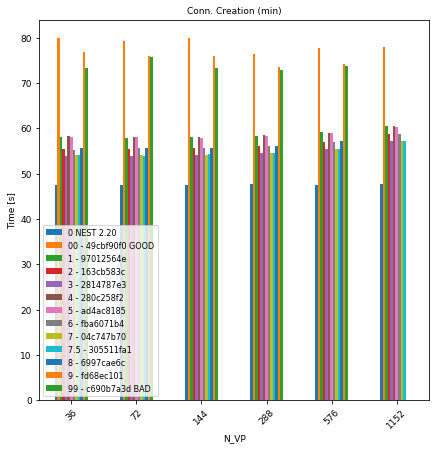

In [8]:
hpc_220 = pd.read_csv('results/hpc_benchmark_2_20_daint.csv')
hpc_220['Case'] = ['0 NEST 2.20'] * len(hpc_220)


hpc_3_49 = pd.read_csv('results/bisect/hpc_benchmark_bisect_49cbf90f0_daint.csv') # GOOD
hpc_3_49['Case'] = ['00 - 49cbf90f0 GOOD'] * len(hpc_3_49)
hpc_3_c6 = pd.read_csv('results/hpc_benchmark_c690b7a3d_daint.csv') # BAD
hpc_3_c6['Case'] = ['99 - c690b7a3d BAD'] * len(hpc_3_c6)

# Bisect:
hpc_3_fd = pd.read_csv('results/bisect/hpc_benchmark_bisect_fd68ec101_daint.csv')
hpc_3_fd['Case'] = ['9 - fd68ec101'] * len(hpc_3_fd)
hpc_3_97 = pd.read_csv('results/bisect/hpc_benchmark_bisect_97012564e_daint.csv')
hpc_3_97['Case'] = ['1 - 97012564e'] * len(hpc_3_97)
hpc_3_69 = pd.read_csv('results/bisect/hpc_benchmark_bisect_6997cae6c_daint.csv')
hpc_3_69['Case'] = ['8 - 6997cae6c'] * len(hpc_3_69)
hpc_3_16 = pd.read_csv('results/bisect/hpc_benchmark_bisect_163cb583c_daint.csv')
hpc_3_16['Case'] = ['2 - 163cb583c'] * len(hpc_3_16)
hpc_3_28 = pd.read_csv('results/bisect/hpc_benchmark_bisect_2814787e3_daint.csv')
hpc_3_28['Case'] = ['3 - 2814787e3'] * len(hpc_3_28)
hpc_3_280 = pd.read_csv('results/bisect/hpc_benchmark_bisect_280c258f2_daint.csv')
hpc_3_280['Case'] = ['4 - 280c258f2'] * len(hpc_3_280)
hpc_3_ad = pd.read_csv('results/bisect/hpc_benchmark_bisect_ad4ac8185_daint.csv')
hpc_3_ad['Case'] = ['5 - ad4ac8185'] * len(hpc_3_ad)
hpc_3_fb = pd.read_csv('results/bisect/hpc_benchmark_bisect_fba6071b4_daint.csv')
hpc_3_fb['Case'] = ['6 - fba6071b4'] * len(hpc_3_fb)
hpc_3_04 = pd.read_csv('results/bisect/hpc_benchmark_bisect_04c747b70_daint.csv')
hpc_3_04['Case'] = ['7 - 04c747b70'] * len(hpc_3_04)
hpc_3_30 = pd.read_csv('results/bisect/hpc_benchmark_bisect_305511fa1_daint.csv')
hpc_3_30['Case'] = ['7.5 - 305511fa1'] * len(hpc_3_30)

# Feilen: 6997cae6c (6997cae6c893470257a0654fe48edb8b799169a0)

hpc_nvp = pd.concat([hpc_220,  hpc_3_49, hpc_3_c6, hpc_3_fd, hpc_3_97, hpc_3_69, hpc_3_16, hpc_3_28, hpc_3_280,
                     hpc_3_ad, hpc_3_fb, hpc_3_04, hpc_3_30])

hpc_nvp = calculate_T_conn_and_memory(hpc_nvp)
values=['Conn. Creation (min)']
hpc_nvp_p = plot_compare(hpc_nvp, 'figures/bisect/hpc_benchmark_weak_scaling_nvp.pdf',
                         values=values, plot_T_sim=False, legend_loc='lower left')

hpc_nvp_p

### TRY AGAIN

Conn. Creation (min)                    
Case            305511fa1 6997cae6c fba6071b4
N_VP                                         
36                  53.95     55.49     55.24
72                  53.97     55.41     55.42
144                 54.08     55.74     55.45
288                 54.56     56.18     56.05
576                 55.45     57.12     57.07
1152                57.39       NaN     58.74

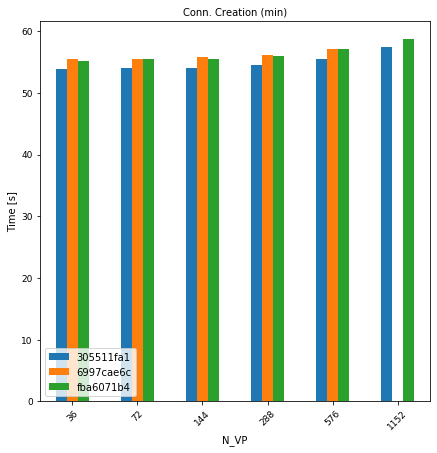

In [15]:

# Bisect:
hpc_3_30 = pd.read_csv('results/bisect/hpc_benchmark_bisect_305511fa1_daint.csv')
hpc_3_30['Case'] = ['305511fa1'] * len(hpc_3_30)
hpc_3_69 = pd.read_csv('results/bisect/hpc_benchmark_bisect_6997cae6c_daint.csv')
hpc_3_69['Case'] = ['6997cae6c'] * len(hpc_3_69)
hpc_3_fb = pd.read_csv('results/bisect/hpc_benchmark_bisect_fba6071b4_daint.csv')
hpc_3_fb['Case'] = ['fba6071b4'] * len(hpc_3_fb)

# 305511fa11e863ba31e38b553d4d4aebdca451d0 is the first bad commit
# commit 305511fa11e863ba31e38b553d4d4aebdca451d0
# Author: weidel-p <phil.weidel@gmail.com>
# Date:   Fri Oct 2 13:25:51 2020 +0200

#     Update pynest/nest/tests/test_jonke_synapse.py
    
#     Co-authored-by: Håkon Bakke Mørk <hakon.mork@nmbu.no>

#  pynest/nest/tests/test_jonke_synapse.py | 3 ---
#  1 file changed, 3 deletions(-)


hpc_nvp = pd.concat([hpc_3_30,  hpc_3_69, hpc_3_fb])

hpc_nvp = calculate_T_conn_and_memory(hpc_nvp)
values=['Conn. Creation (min)']
hpc_nvp_p = plot_compare(hpc_nvp, 'figures/bisect/hpc_benchmark_weak_scaling_nvp.pdf',
                         values=values, plot_T_sim=False, legend_loc='lower left')

hpc_nvp_p